# **0. 참고자료**
## **0-1. 도서**   
- 한빛미디어 | 오가와 유타로 저, 박광수 역 - 만들면서 배우는 파이토치 딥러닝  

## **0-2. 논문, 학술지**

## **0-3. 웹 사이트**

## **0-4. 데이터셋 출처**
- Kaggle - Rice Image Dataset | [[데이터 셋 링크]](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset)


In [1]:
## json 파일 업로드 확인
!ls -1ha ~/dove/TIL/api/kaggle.json

## 캐글 숨김 폴더 생성
!mkdir -p ~/.kaggle

## 토큰 파일 옮기고, 권한 부여
!cp  ~/dove/TIL/api/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## 데이터 셋 다운로드
!kaggle datasets download -d muratkokludataset/rice-image-dataset

## 파일 옮기기
!mkdir -p ~/dove/TIL/AI_study/datasets/zip
!mv rice-image-dataset.zip ~/dove/TIL/AI_study/datasets/zip/rices.zip

/home/jovyan/dove/TIL/api/kaggle.json
100%|███████████████████████████████████████▉| 219M/219M [00:04<00:00, 74.0MB/s]
100%|████████████████████████████████████████| 219M/219M [00:04<00:00, 46.6MB/s]


In [ ]:
!unzip ~/dove/TIL/AI_study/datasets/zip/rices.zip -d ~/dove/TIL/AI_study/datasets/rices

In [2]:
## 미리 만들어둔 데이터 모듈 이용
from sklearn.model_selection import train_test_split
from utils import dataset_util
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import random

In [ ]:
(images, labels), (lb2idx, idx2lb) = dataset_util.build_dataset('/home/jovyan/dove/TIL/AI_study/datasets/rices/Rice_Image_Dataset')

In [ ]:
train_img, valid_img, train_lb, valid_lb = train_test_split(images, labels, stratify = labels, test_size = 0.3, shuffle = True, random_state = 42)
train_img, test_img, train_lb, test_lb = train_test_split(train_img, train_lb, stratify = train_lb, test_size = 0.3, shuffle = True, random_state = 42)

In [ ]:
train_img.shape, test_img.shape, valid_img.shape

In [ ]:
train_sample_idx = random.sample(range(len(train_img)), 3) 

f, axes = plt.subplots(1, 3)
f.set_size_inches((20, 5))

for idx, sample_idx in enumerate(train_sample_idx):
    axes[idx].imshow(train_img[sample_idx])
    axes[idx].axis(False)
    axes[idx].set_title(idx2lb[train_lb[sample_idx]])

In [ ]:
valid_sample_idx = random.sample(range(len(valid_img)), 3) 

f, axes = plt.subplots(1, 3)
f.set_size_inches((20, 5))

for idx, sample_idx in enumerate(valid_sample_idx):
    axes[idx].imshow(valid_img[sample_idx])
    axes[idx].axis(False)
    axes[idx].set_title(idx2lb[valid_lb[sample_idx]])

In [ ]:
test_sample_idx = random.sample(range(len(test_img)), 3) 

f, axes = plt.subplots(1, 3)
f.set_size_inches((20, 5))

for idx, sample_idx in enumerate(test_sample_idx):
    axes[idx].imshow(test_img[sample_idx])
    axes[idx].axis(False)
    axes[idx].set_title(idx2lb[test_lb[sample_idx]])

In [ ]:
def display_distribution(labels, add_num = 100):
  
    f, axes = plt.subplots(1, 3)
    f.set_size_inches((20, 5))

    for idx, (label, dtype) in enumerate(zip(labels, ('train', 'valid', 'test'))):
        lb_count  = Counter(label)
        max_count = max(lb_count.values())
        
        axes[idx].bar(lb_count.keys(), lb_count.values())
        axes[idx].set_ylim(0, max_count + add_num)
        axes[idx].set_title(f'{dtype} dataset')

        for grade, num in lb_count.items():
          axes[idx].text(
                      grade, num, num,
                      fontsize = 11, color = 'black',
                      horizontalalignment = 'center',
                      verticalalignment = 'bottom'
                  )
    plt.show()

display_distribution((train_lb, valid_lb, test_lb), add_num = 1000)

In [34]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torch

/opt/conda/envs/bio/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
USE_CUDA = torch.cuda.is_available()
DEVICE   = torch.device('cuda' if USE_CUDA else 'cpu')

BATCH_SIZE = 32 
MOMENTUM   = 0.9
EPOCHS     = 100
STEP       = 30
LR         = 1e-2

In [38]:
class RicesDataset(Dataset):
    
    def __init__(self, images, labels, dtype = 'train'):
        
        self.images = images
        self.labels = labels
        self.dtype  = dtype
        
        self.transforms          = {}
        self.transforms['train'] = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.CenterCrop(size=(250, 250)),
                                                transforms.ToTensor()
                                            ])
        self.transforms['valid'] = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.Resize(250),
                                                transforms.ToTensor()
                                            ])
        
        self.transforms['test'] = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.Resize(250),
                                                transforms.ToTensor()
                                            ])
        
        self.num_datas = self.labels.shape[0]
        
    
    def __getitem__(self, index):
        
        image = self.images[index]
        image = self.transforms[self.dtype](image)
        
        return image, self.labels[index]
    
    def __len__(self):
        return self.num_datas

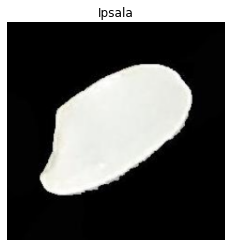

In [41]:
train_dataset  = RicesDataset(train_img, train_lb)
train_loader   = DataLoader(train_dataset, batch_size = BATCH_SIZE)

train_iter     = iter(train_loader)
images, labels = next(train_iter)
image, lb      = images[3], labels[3]

dataset_util.display_image((image, lb.item()), idx2lb)

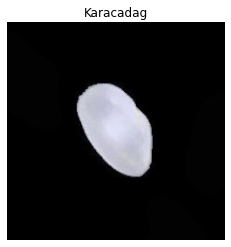

In [45]:
valid_dataset  = RicesDataset(valid_img, valid_lb)
valid_loader   = DataLoader(valid_dataset, batch_size = BATCH_SIZE)

valid_iter     = iter(valid_loader)
images, labels = next(valid_iter)
image, lb      = images[31], labels[31]

dataset_util.display_image((image, lb.item()), idx2lb)

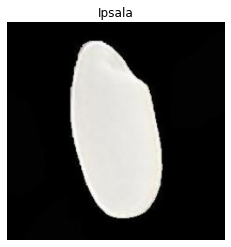

In [44]:
test_dataset   = RicesDataset(test_img, test_lb)
test_loader    = DataLoader(test_dataset, batch_size = 1)

test_iter     = iter(test_loader)
images, labels = next(test_iter)
image, lb      = images[0], labels[0]

dataset_util.display_image((image, lb.item()), idx2lb)

In [48]:
from torchvision import models

In [46]:
def train(model, train_loader, optimizer):
    model.train()
    train_loss, correct = 0, 0
    
    for image, lb in train_loader:
        image, lb   = image.to(DEVICE), lb.to(DEVICE)
        optimizer.zero_grad()
        
        output = model(image)
        loss   = F.cross_entropy(output, lb)
        
        loss.backward()
        optimizer.step()
        
        pred = output.max(1, keepdim = True)[1]
        correct += pred.eq(lb.view_as(pred)).sum().item()
        train_loss += loss
        
    train_loss /= len(train_loader.dataset)
    train_acc   = 100 * correct / len(train_loader.dataset)
    
    return train_loss, train_acc


def evaluate(model, test_loader):
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for img, lb in test_loader:
            img, lb   = img.to(DEVICE), lb.to(DEVICE)
            output = model(img)
            
            loss   = F.cross_entropy(output, lb)
            pred = output.max(1, keepdim = True)[1]
            
            correct += pred.eq(lb.view_as(pred)).sum().item()
            test_loss += loss
        
    test_loss /= len(test_loader.dataset)
    test_acc   = 100 * correct / len(test_loader.dataset)
    
    return test_loss, test_acc   

In [52]:
class FinetuneNet(nn.Module):
    
    def __init__(self, num_classes):
        
        super(FinetuneNet, self).__init__()
        
        self.model = models.resnet50(pretrained = True)
        self.model.classifier = nn.Sequential(
                                    nn.Linear(in_features = 1792, out_features = 640),
                                    nn.ReLU(),
                                    nn.Dropout(p = 0.3),
                                    nn.Linear(in_features = 640, out_features = num_classes)
                                )
        
    def forward(self, x):
        output = self.model(x)
        return output

model = FinetuneNet(num_classes = 5).to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 37.3MB/s]


In [53]:
optimizer = optim.SGD(model.parameters(), lr = LR, momentum = MOMENTUM)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = STEP, gamma = 0.1)

## 기존 학습 과정과는 다르게 로그 그래프도 그려보기 위해 리스트를 생성함.
history = {
                'train_loss' : [],
                'train_acc'  : [],
                'valid_loss' : [],
                'valid_acc'  : []
            }

## 학습을 돌려보자
for epoch in range(1, EPOCHS + 1):
  scheduler.step()

  train_loss, train_acc = train(model, train_loader, optimizer)
  history['train_loss'].append(train_loss.item())
  history['train_acc'].append(train_acc)

  valid_loss, valid_acc = evaluate(model, valid_loader)
  history['valid_loss'].append(valid_loss.item())
  history['valid_acc'].append(valid_acc)
    
  print(f'[{epoch} / {EPOCHS}] \nTrain Loss : {train_loss:.3f} | Train Acc : {train_acc:.3f} \nValid Loss : {valid_loss:.3f} | Valid Acc : {valid_acc:.3f} \n')

[1 / 100] 
Train Loss : 0.002 | Train Acc : 97.837 
Valid Loss : 0.102 | Valid Acc : 59.373 

[2 / 100] 
Train Loss : 0.000 | Train Acc : 99.521 
Valid Loss : 0.000 | Valid Acc : 99.800 

[3 / 100] 
Train Loss : 0.000 | Train Acc : 99.733 
Valid Loss : 0.008 | Valid Acc : 93.320 

[4 / 100] 
Train Loss : 0.000 | Train Acc : 99.739 
Valid Loss : 0.001 | Valid Acc : 99.502 

[5 / 100] 
Train Loss : 0.000 | Train Acc : 99.837 
Valid Loss : 0.000 | Valid Acc : 99.711 

[6 / 100] 
Train Loss : 0.000 | Train Acc : 99.946 
Valid Loss : 0.000 | Valid Acc : 99.804 

[7 / 100] 
Train Loss : 0.000 | Train Acc : 99.916 
Valid Loss : 0.000 | Valid Acc : 99.653 

[8 / 100] 
Train Loss : 0.000 | Train Acc : 99.899 
Valid Loss : 0.000 | Valid Acc : 99.818 

[9 / 100] 
Train Loss : 0.000 | Train Acc : 99.899 
Valid Loss : 0.000 | Valid Acc : 99.813 

[10 / 100] 
Train Loss : 0.000 | Train Acc : 99.907 
Valid Loss : 0.000 | Valid Acc : 99.920 

[11 / 100] 
Train Loss : 0.000 | Train Acc : 99.995 
Valid 